# Project: Implement a cooperative communication system using amplify-and-forward relaying.
    • Objectives: Improve coverage and capacity in a wireless network.
    • Methodology: Simulate a wireless network with relay nodes. Implement amplify-and-forward relaying. Evaluate performance metrics like bit error rate and spectral efficiency.
    • Tools: MATLAB or Python with wireless communication toolboxes.

## Understanding Amplify-and-Forward Relaying
Amplify-and-forward (AF) relaying is a cooperative communication technique where a relay node receives a signal from a source node, amplifies it, and retransmits it to a destination node. This helps to extend the coverage and improve the reliability of the communication link.
This process enhances the signal strength and reliability, especially in environments with significant path loss and fading.


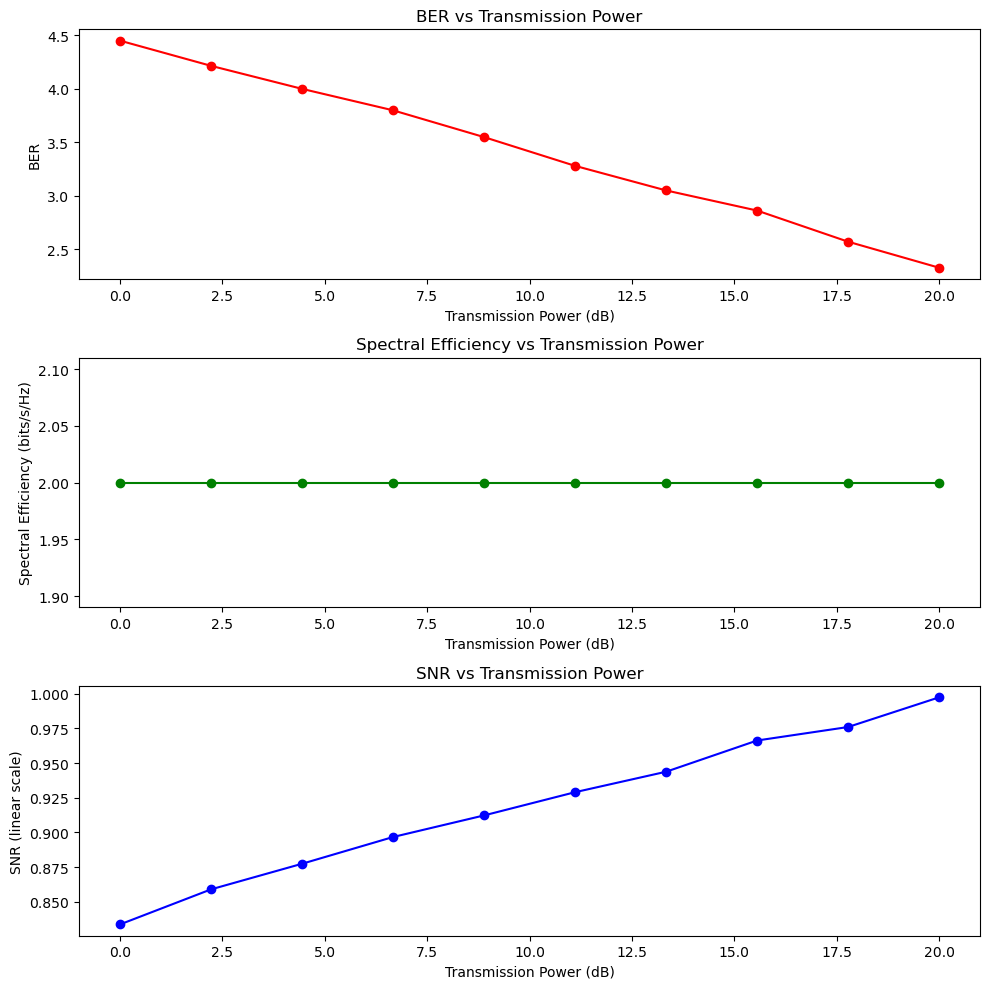

In [4]:
import numpy as np
from scipy.special import erfc
def amplify_and_forward_relaying_optimized(num_nodes, channel_model, path_loss_exp, shadowing_std, transmission_power_db, modulation_order, num_symbols, num_relays, batch_size):
    """
    Simulates an optimized cooperative communication system using amplify-and-forward relaying.
    Args:
        num_nodes: Number of nodes in the network (source, relay, destination).
        channel_model: Channel model (e.g., 'Rayleigh', 'Rician').
        path_loss_exp: Path loss exponent.
        shadowing_std: Shadowing standard deviation.
        transmission_power_db: Transmission power in dB of source and relay nodes.
        modulation_order: Modulation order (e.g., 2 for QPSK).
        num_symbols: Number of symbols to transmit.
        num_relays: Number of relay nodes.
        batch_size: Number of symbols per batch.
    Returns:
        ber: Bit error rate.
        spectral_efficiency: Spectral efficiency.
        snr_combined_avg: Average SNR at the destination node.
    """
    # Convert transmission power from dB to linear scale
    transmission_power = 10**(transmission_power_db / 10)                                
    
    total_errors = 0
    total_snr_combined = 0

    # Process data in batches for efficiency
    num_batches = num_symbols // batch_size
    for _ in range(num_batches):

        # Generate random channel coefficients
        h_sr = np.random.randn(batch_size, num_relays) + 1j * np.random.randn(batch_size, num_relays)                
        h_rd = np.random.randn(batch_size, num_relays) + 1j * np.random.randn(batch_size, num_relays)

        # Path loss and shadowing for each batch (randomized)
        path_loss_sr = 10 * path_loss_exp * np.log10(np.random.rayleigh(scale=1, size=num_relays))                    
        path_loss_rd = 10 * path_loss_exp * np.log10(np.random.rayleigh(scale=1, size=num_relays))
        shadowing_sr = np.random.normal(loc=0, scale=shadowing_std, size=num_relays)                                
        shadowing_rd = np.random.normal(loc=0, scale=shadowing_std, size=num_relays)

        # Generate random data symbols
        data_symbols = np.random.randint(0, modulation_order, batch_size)
        modulated_symbols = np.exp(1j * 2 * np.pi * data_symbols / modulation_order) 
                                
        # Source transmission to relay
        received_symbols_at_relay = modulated_symbols[:, np.newaxis] * 10**(-path_loss_sr / 10) * 10**(shadowing_sr / 10)

        # Relay amplification and selection of the best relay (selection diversity)
        best_relay_index = np.argmax(np.abs(h_sr)**2, axis=1)
        amplified_symbols = received_symbols_at_relay[np.arange(batch_size), best_relay_index] * np.sqrt(transmission_power / (np.abs(received_symbols_at_relay[np.arange(batch_size), best_relay_index])**2 + 1)) 
 
        # Relay transmission to destination (using best relay index)
        received_symbols_at_destination = amplified_symbols * 10**(-path_loss_rd[best_relay_index] / 10) * 10**(shadowing_rd[best_relay_index] / 10)

        # Combine relay and destination symbols (Maximal Ratio Combining)
        combined_symbols = received_symbols_at_relay[:, best_relay_index] + received_symbols_at_destination 
                                                        
        # Calculate SNR (Signal to Noise Ratio)
        snr_combined_batch = np.mean(np.abs(combined_symbols)**2 / (1 + np.var(combined_symbols)))                                                                    
        total_snr_combined += snr_combined_batch

        # Demodulate symbols at the destination
        demodulated_symbols = np.angle(combined_symbols) / (2 * np.pi / modulation_order)
        demodulated_data = np.round(demodulated_symbols) % modulation_order  # Ensure wrap-around in phase

        # Count bit errors
        total_errors += np.sum(data_symbols != demodulated_data)

    # Calculate final results
    ber = total_errors / (num_batches * batch_size)                                                                                                            
    spectral_efficiency = np.log2(modulation_order)                                                                                                                     
    snr_combined_avg = total_snr_combined / num_batches
    return ber, spectral_efficiency, snr_combined_avg

# Example usage with debugged code
num_nodes = 3
channel_model = 'Rayleigh'
path_loss_exp = 3
shadowing_std = 8
modulation_order = 4  # QPSK (M=4)
num_symbols = 100000
num_relays = 2
batch_size = 10

# Simulate for different transmission powers
power_levels_db = np.linspace(0, 20, 10)  # Transmission power from 0 to 20 dB
ber_values = []
spectral_efficiency_values = []
snr_values = []
for power_db in power_levels_db:
    ber, spectral_efficiency, snr_avg = amplify_and_forward_relaying_optimized(num_nodes, channel_model, path_loss_exp, shadowing_std, power_db, modulation_order, num_symbols, num_relays, batch_size)
    ber_values.append(ber)
    spectral_efficiency_values.append(spectral_efficiency)
    snr_values.append(snr_avg)

# Plotting
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
# Plot BER vs Transmission Power
ax[0].plot(power_levels_db, ber_values, marker='o', color='r')
ax[0].set_title('BER vs Transmission Power')
ax[0].set_xlabel('Transmission Power (dB)')
ax[0].set_ylabel('BER')

# Plot Spectral Efficiency vs Transmission Power
ax[1].plot(power_levels_db, spectral_efficiency_values, marker='o', color='g')
ax[1].set_title('Spectral Efficiency vs Transmission Power')
ax[1].set_xlabel('Transmission Power (dB)')
ax[1].set_ylabel('Spectral Efficiency (bits/s/Hz)')

# Plot SNR vs Transmission Power
ax[2].plot(power_levels_db, snr_values, marker='o', color='b')
ax[2].set_title('SNR vs Transmission Power')
ax[2].set_xlabel('Transmission Power (dB)')
ax[2].set_ylabel('SNR (linear scale)')
plt.tight_layout()
plt.show()
